### Victoria Liu
### Progress Report

#### Literature Review
Over the past few weeks, I've been conducting a literature search on suitable GAN architectures and suitable loss functions for MRI super-resolution. I found these two papers particularly promising: Deora et al.'s [*Structure Preserving Compressive Sensing MRI Reconstruction using Generative Adversarial Networks*](https://arxiv.org/abs/1910.06067) and Sanchez et al. [*Brain MRI super-resolution using 3D generative adversarial networks*](https://arxiv.org/pdf/1812.11440.pdf). Both papers use convolution $\rightarrow$ batch normalization $rightarrow$ LeakyReLu blocks in their generators and discriminators, and both implement residual blocks in the generator. Notably, Sanchez's paper uses 3D convolutions, while Deora's paper uses 2D convolutions on 2D slices of MRI images. In addition, neither paper uses the binary cross entropy loss function originally associated with GANs; Sanchez uses a least square function with binary coding, while Deora uses three weighted loss functions: $l1$ loss, Wasserstein loss, and mean SSIM (structural similarity index). After comparing the two papers' results, I felt that Deora's network had both qualitatively and quantitatively better results. I thought their multiple losses also made sense because the different losses helped improve different aspects of learning that were all crucial: $l1$ to deblur low frequency elements, SSIM to account for the human visual system, and Wasserstein to eliminate vanishing. In addition, the discriminator analyzed the authenticities of multiple "patches" of the MRI and would give an average authenticity. However, I thought Sanchez's use of the 3D convolutions could leverage volumetric data that might enhance superresolution. As such, my project's main goal is to implement 3D convolutions using the GAN structure that Deora et al. have; I am also trying to see how different kernel weight initizations affect the accuracy of the model.


#### Current Progress & Potential Issues
Deora et al. published their code on [Github](https://github.com/puneesh00/cs-mri-gan), and I've been able to change from 2D convolutions to 3D convolutions and add a parameter for kernel initialization. I haven't run any of the models yet, since I'm still finishing the code. I've also been having some trouble with the GPU, but I have already reached out to you all about that. I anticipate making the model a lot smaller than Deora's, since I have way less training data than they did; I have around $100$ MRIs, while they had over $20,000$. As of right now, the model has $501,905,202$ parameters, which is a very high number. I anticipate some debate about which parts of the network to cut down, and I will go to office hours to discuss this. Also a note: the dataset size is bottlenecked by the disc space on the clusters; the source of my MRI samples has thousands of MRIs. I will reach out to Morgan to see if the disc space can be increased.

#### Plan For Next Few Weeks
I first need to split my training and testing data before I run anything. Then, I would like to run my model on a small batch of data soon, and see if my model might be overfitting the data. I would also like to try out different kernel weight initializations. I anticipate a lot of debugging and network architecture modification in the coming weeks. I hope to be able to compare some accuracy and loss metrics between my models by next week. I will also start planning my final presentation and paper as well.

#### Code
I will now show the code and explain which parts I've written or changed since last time. This next block is all from the data preprocessing assignment:

In [3]:
import os
import glob

# h5py can read hdf5 dataset
import h5py

# delete bad data files
from send2trash import send2trash

# fastmri has some k-space undersampling functions we can use
# git clone https://github.com/facebookresearch/fastMRI.git
# go to the fastmri directory
# pip install -e.
import fastmri

# We will use this functions to generate masks
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

# sigpy is apparently a good MRI viewing tool
# pip install sigpy
import sigpy as sp
import sigpy.plot as pl

import numpy as np
import tensorflow as tf

# keras frontend for building the discriminator,
# generator, and GAN models
from keras.models import Model, Input
from keras.optimizers import Adam

from keras.layers import Dense
from keras.layers import Conv3D, Conv3DTranspose
from keras.layers import Add, Concatenate
from keras.layers import Activation, LeakyReLU
from keras.layers import BatchNormalization, Lambda

# backend, sort of like numpy but does everything in tf tensors
from keras import backend as K


import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

In [2]:
# define constants
DATASET = 'singlecoil_train'
AXES = {
        'singlecoil_train' : (1, 2),
        'multicoil_train' : (2, 3),
       }
PATH = os.path.join(os.getcwd(), DATASET)
mri_paths = glob.glob(os.path.join(PATH, '*1.h5'))

In [14]:
# this block gets Dataset object with imaginary and real separated
def _get_kspace_and_reconstruction_rss(filename):
    """
    @params filename: full path to .h5 mri file
    @return kspace data of that particular file
    """
    try:
        with h5py.File(filename, 'r') as hr:
            return hr['kspace'][:], hr['reconstruction_rss'][:]
    except:
        print(f'Error could not open {filename}')

def _get_kspace_undersampled(kspace, center_fractions = [0.04], accelerations = [4]):
    """
    @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params center_fractions: for undersampling, 
        N*center_fraction columns in center corresponding to low-frequencies
    @params accelerations: how much mri acquisition is sped up
    @return undersampled k-space
    """
    mask_func = RandomMaskFunc(
        center_fractions = center_fractions, 
        accelerations = accelerations
    )
    mask = np.array(mask_func(kspace.shape))
    return kspace * mask

I realized that since the undersampled data has both a real and imaginary component, they need to be separated out and passed as two arrays of real numbers into the generator. Based on an Internet search, I do not believe TensorFlow can deal with the gradients of complex numbers, so the a way to deal with this is to simply pass the real and imaginary components as two separate channels. In addition, since the convolutional layers have stride $2$ and `same` padding, it is probably best to have the input shape be divisible by $2$; as such, the input shape for the generator is now $(32, 256, 256, 2)$ (and the input shape for the discriminator is $(32, 256, 256, 1)$) where the number of channels comes last.

In [14]:
def _get_mri_im_separated(
#     kspace, 
    reconstruction_rss,
    kspace_undersampled, 
    DATASET
):
    """
    separates imaginary from real values
    # @params kspace: from _get_kspace_and_reconstruction_rss(filename)
    @params reconstruction_rss: reconstructed MR image of fully sampled kspace, provided
    @params kspace_undersampled: mask-undersampled k-space from _get_kspace_undersampled
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_im = sp.ifft(kspace_undersampled, axes=AXES[DATASET])
    
    #crop to make sure images are all the same size
    undersampled_crop = sp.resize(
        undersampled_im,
        [1, 32, 256, 256]
    )
    
    undersampled_crop_real = tf.math.real(undersampled_crop)
    undersampled_crop_imag = tf.math.imag(undersampled_crop)
    
    undersampled_crop = np.stack(
        (undersampled_crop_real, undersampled_crop_imag),
        axis = 4,
    )
    
    
    fullysampled_crop = sp.resize(
        reconstruction_rss,
        [1, 32, 256, 256]
    )
    
    
    return (
        undersampled_crop,
        fullysampled_crop,
    )
    


def get_datum_from_single_file_separated(filename, DATASET):
    """
    user-facing function for tf Dataset object; separates real and imag
    @params filename: full path to .h5 mri file
    @params DATASET: i.e. 'singlecoil_challenge' or 'multicoil_challenge'
    @return (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    kspace, reconstruction_rss = _get_kspace_and_reconstruction_rss(filename)
    kspace_undersampled = _get_kspace_undersampled(kspace)
    return _get_mri_im_separated(
        reconstruction_rss,
        kspace_undersampled,
        DATASET,
    )


def get_data_from_files_separated(filenames, DATASET):  
    """
    user-facing function for tf Dataset object; separates real and imag
    @params filenames: list of full paths to .h5 mri files
    @params DATASET: i.e. 'singlecoil_train' or 'multicoil_train'
    @return ndarray of 
        (undersampled mri image, fully sampled mri image (i.e. label for GAN))
    """
    undersampled_images = np.ones((1, 32, 256, 256, 2)) #[bn, h, l, w, c]
    fullysampled_images = np.ones((1, 32, 256, 256))
    for mri_path in filenames:
        try:
            # undersampled_crop has real and imag components
            undersampled_crop, fullysampled_crop = get_datum_from_single_file_separated(
                mri_path, DATASET
            )
               

            undersampled_images = np.vstack(
                (undersampled_images, undersampled_crop)
            )
            
            
            fullysampled_images = np.vstack(
                (fullysampled_images, fullysampled_crop)
            )
            
#             print (f'undersampled image shape: {undersampled_crop.shape}')           
#             print (f'undersampled images running total shape: {undersampled_images.shape}')
#             print (f'fully sampled images running total shape {fullysampled_images.shape}')
#             print ()
            
            
        except:
            print(f'could not open file {mri_path}')
#             send2trash(mri_path)
            print(f'sent file {mri_path} to trash')
    
    # reshape with extra one at the end for channel
    fullysampled_images = fullysampled_images.reshape(
        (-1, 32, 256, 256, 1)
    )


    return undersampled_images[1:], fullysampled_images[1:]

#

In [ ]:
under_sampled_separated, fully_sampled_separated = get_data_from_files_separated(mri_paths, DATASET)
ds_separated = tf.data.Dataset.from_tensor_slices((under_sampled_separated, fully_sampled_separated))
ds_separated = ds_separated.shuffle(150, seed = 123, reshuffle_each_iteration = True)

Since the real and imaginary components are now separated, plotting a `.take(1)` wouldn't make as much visual sense as the plot containing both real and imaginary values. Nevertheless, we can still plot both for fun, just to check that our code worked:

<IPython.core.display.Javascript object>


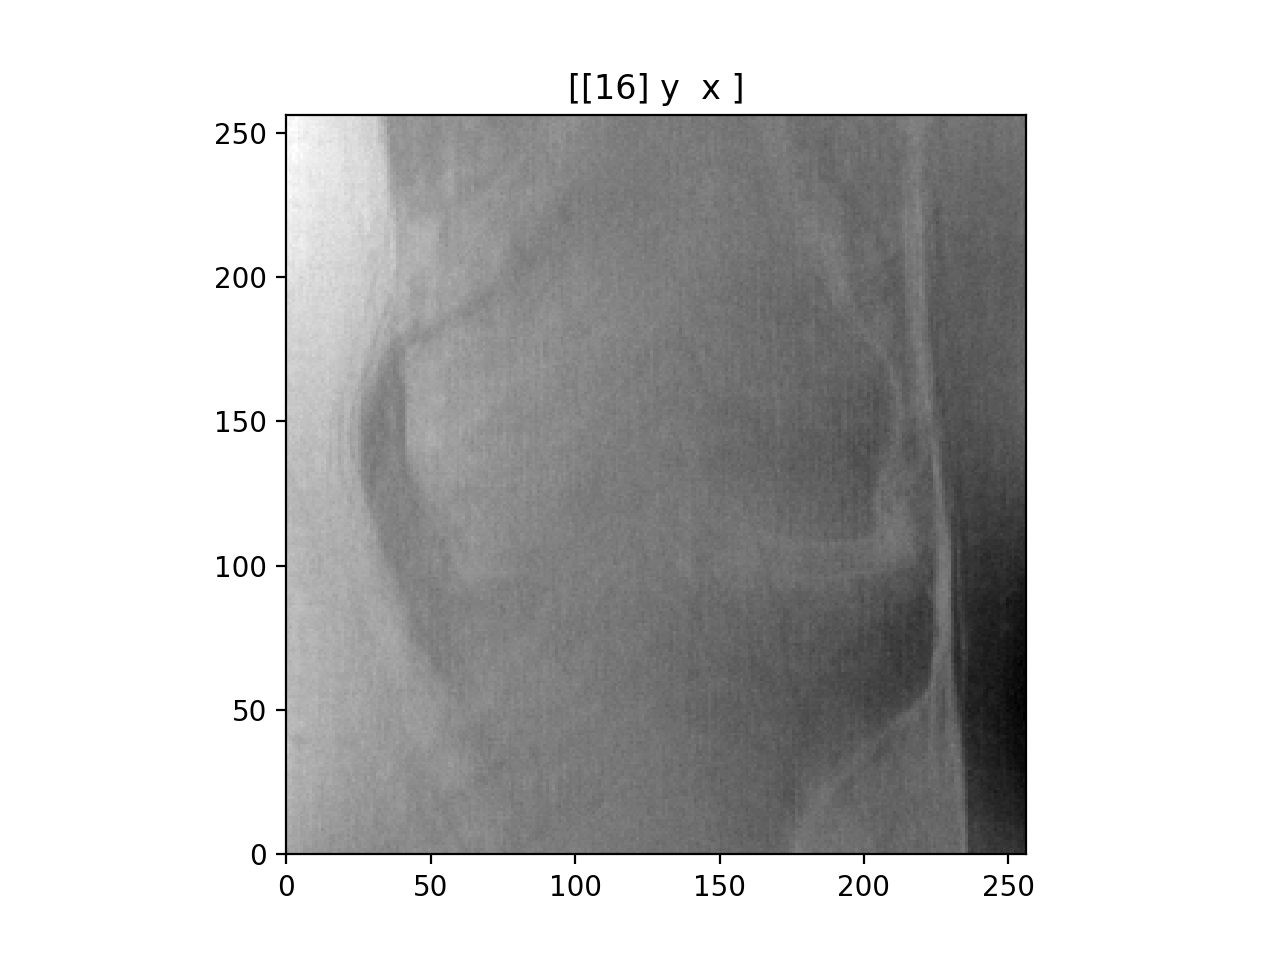

<IPython.core.display.Javascript object>


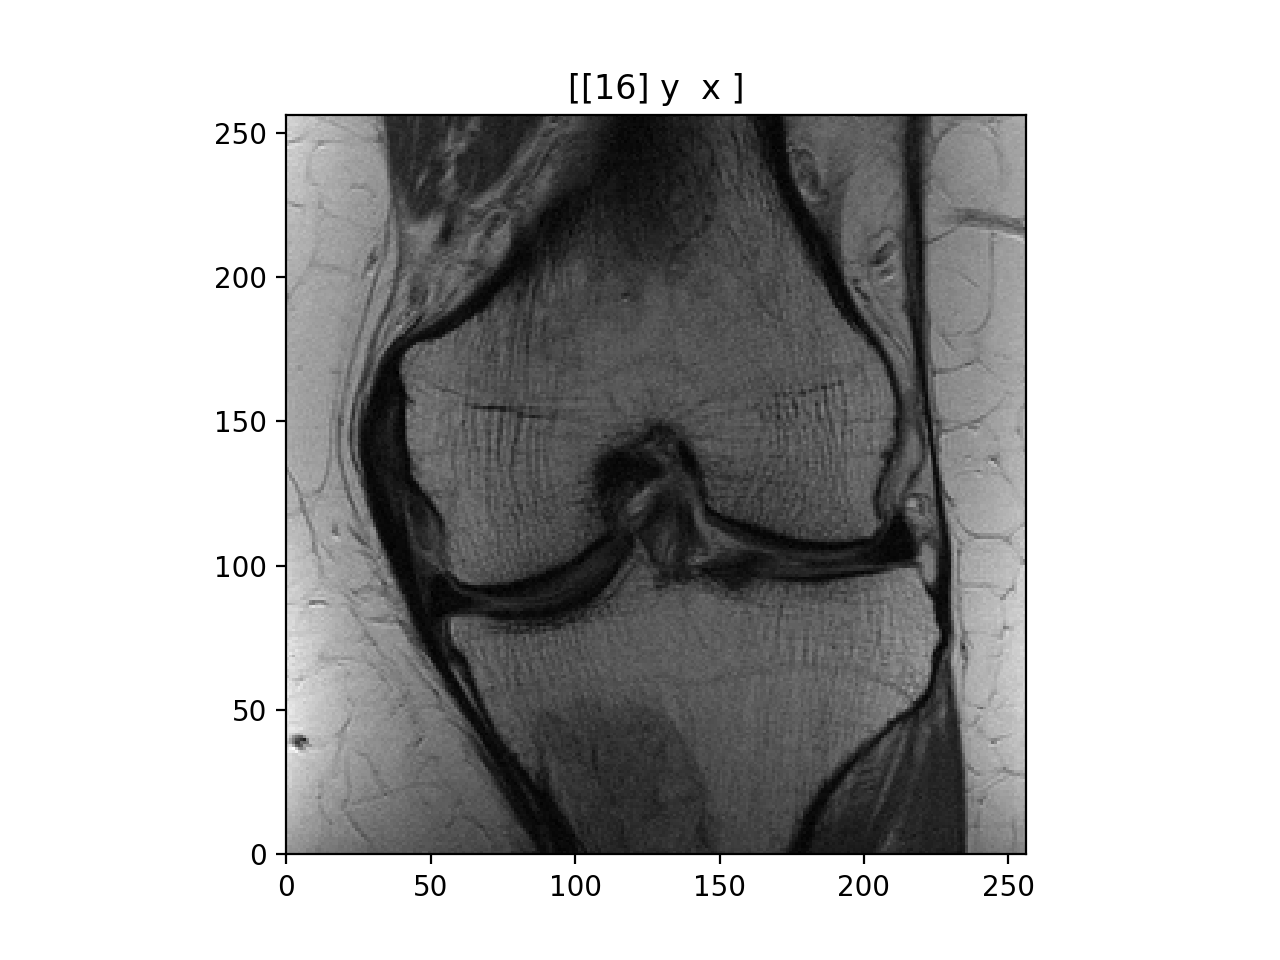

<IPython.core.display.Javascript object>


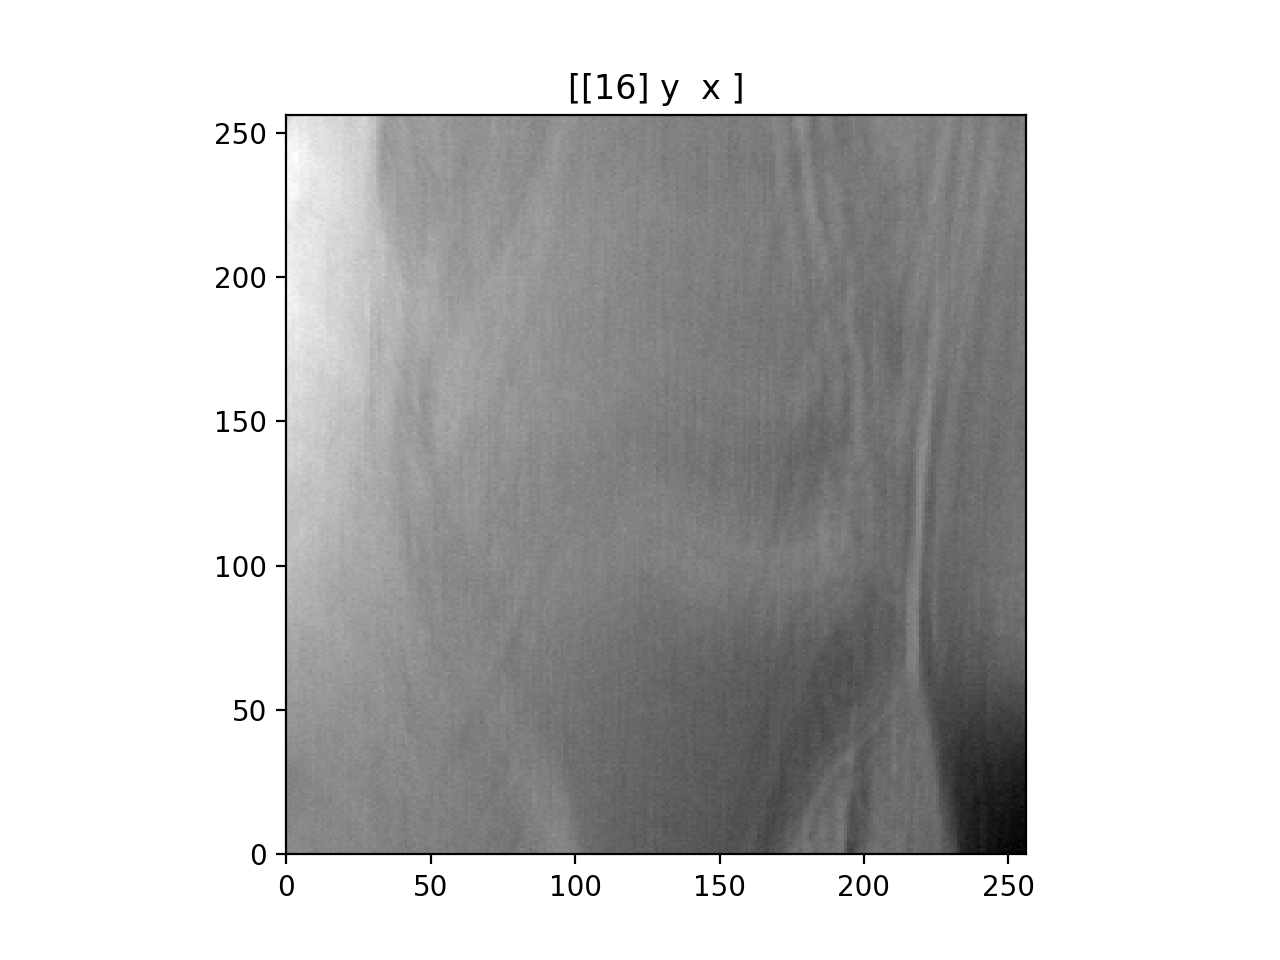

<IPython.core.display.Javascript object>


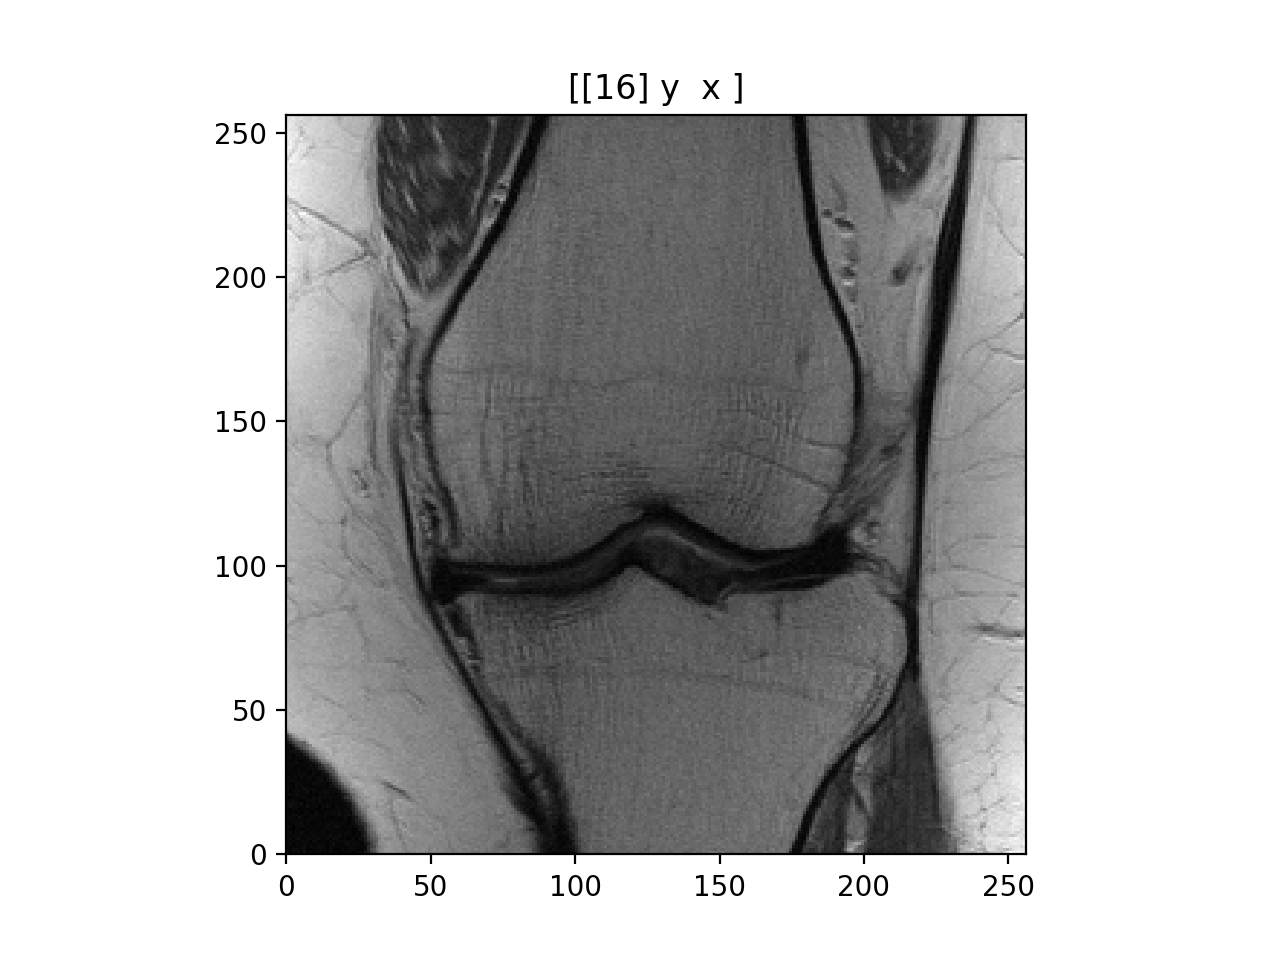

<IPython.core.display.Javascript object>


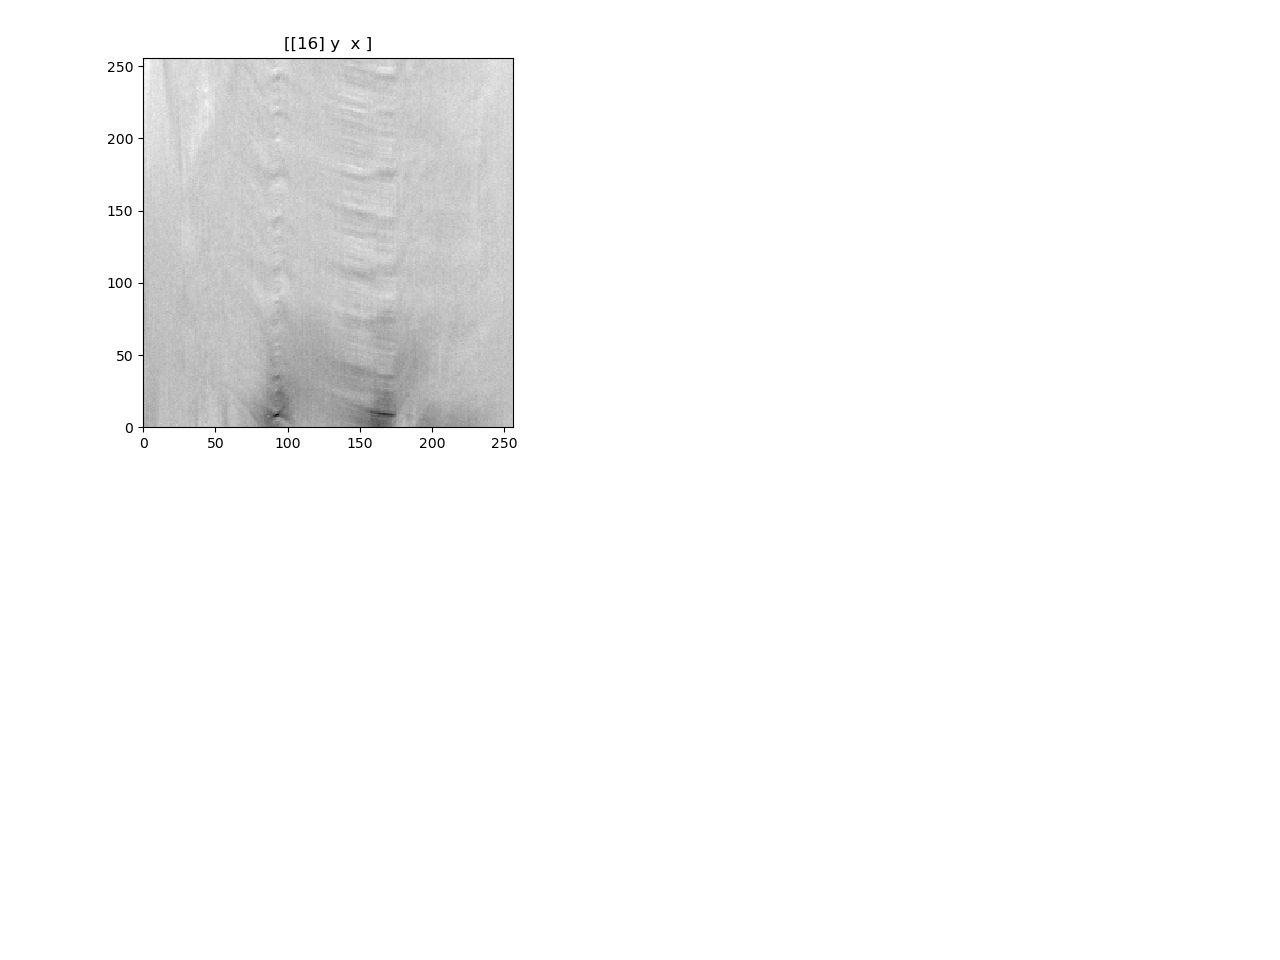

<IPython.core.display.Javascript object>


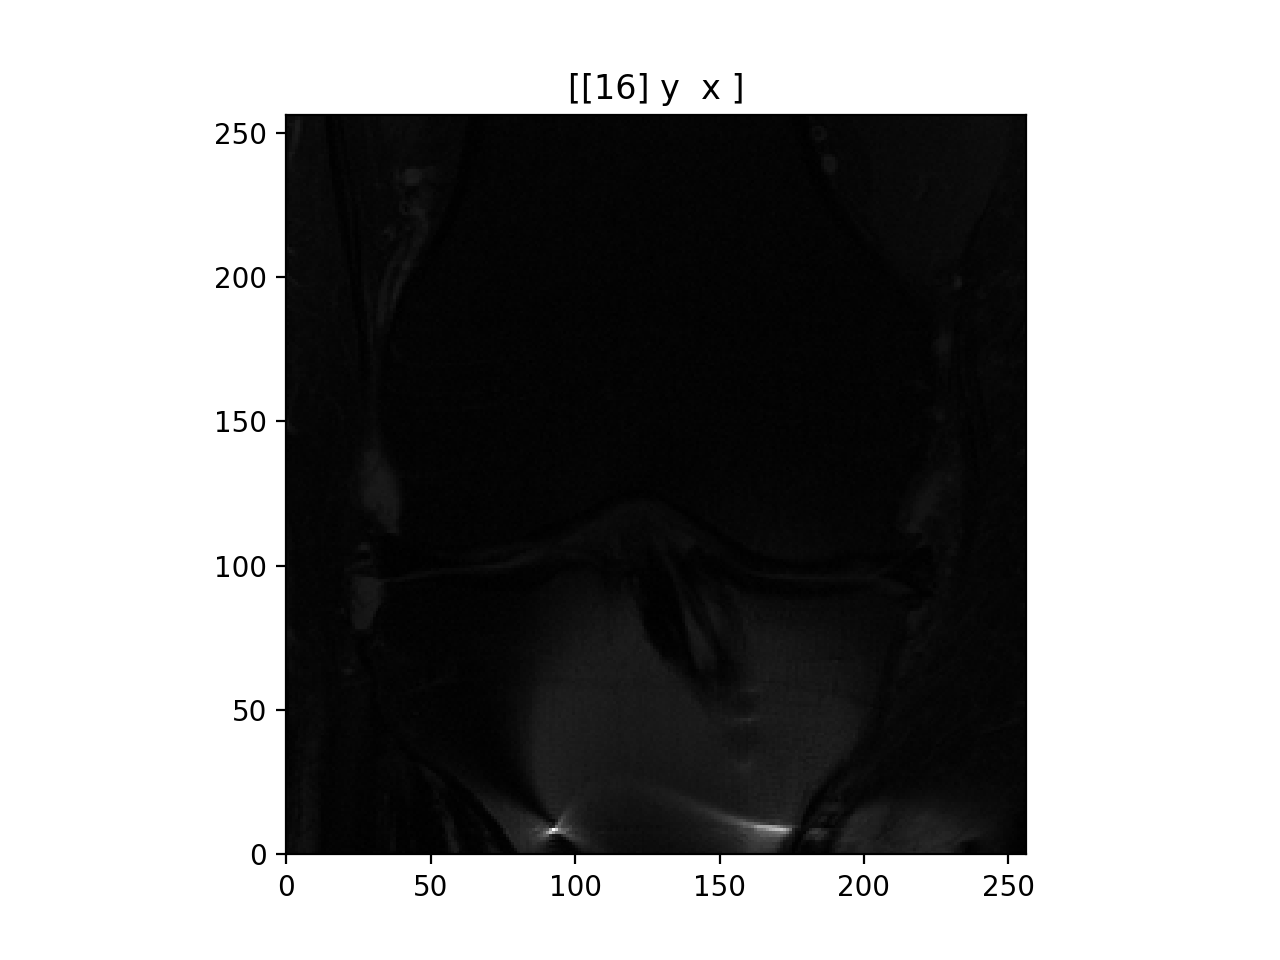

In [22]:
for undersampled_im, fullysampled_im in ds_separated.take(1):
    pl.ImagePlot(undersampled_im[:, :, :, 1]) #this is just imaginary numbers. Don't use this in comparison
    pl.ImagePlot(fullysampled_im[:, :, :, 0])

This next code represents the accuracy metric, the mean SSIM loss function, and the Wasserstein loss function. This code block is pretty much unchanged from Deora's Github code.

In [3]:
def accm(y_true, y_pred):
    '''
    accuracy metric
    '''
    y_pred = K.clip(y_pred, -1, 1)
    return K.mean(K.equal(y_true, K.round(y_pred)))

def mssim(y_true, y_pred):
    '''
    mean structural similarity index
    '''
    costs = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return costs

def wloss(y_true, y_predict):
    '''
    Wasserstein loss
    '''
    return -K.mean(y_true * y_predict)

The discriminator code was modified to take in a 3D input of size $(32, 256, 256, 1)$, and the 2D convolutions were changed to 3D convolutions. This change also involved changing the strides, so that the patch that comes out of the discriminator is a $4 \times 4 \times 4$ patch that is used to score authenticity. In addition, the number of filters were decreased significantly, since I had some OOM errors when compiling the discriminator model when there were more than $16 \cdot 8$ filters at any given moment. Finally, I plan on playing around with both `he_normal` and `glorot_uniform` kernel weight initializations, so I added a `kernel_initz` input variable.

In [10]:
def discriminator(
    kernel_initz,
    inp_shape = (32, 256, 256, 1), # 3d, with channels last
    trainable = True,
):
    
    gamma_init = tf.random_normal_initializer(1., 0.02)
    
    inp = Input(shape = (32, 256, 256, 1)) # 3d
    
    l0 = Conv3D(
        filters = 16, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(inp)
    l0 = LeakyReLU(alpha = 0.2)(l0)
    
    
    l1 = Conv3D(
        filters = 16 * 2, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(l0)
    l1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l1)
    l1 = LeakyReLU(alpha = 0.2)(l1)
    
    
    l2 = Conv3D(
        filters = 16 * 4, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(l1)
    l2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l2)
    l2 = LeakyReLU(alpha = 0.2)(l2)
    
    
    l3 = Conv3D(
        filters = 16 * 8, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz, 
        )(l2)
    l3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l3)
    l3 = LeakyReLU(alpha = 0.2)(l3)
    
    
    l4 = Conv3D(
        filters = 16 * 16, kernel_size = 4, strides = (2, 2, 2),
        padding = 'same', kernel_initializer = kernel_initz,
        )(l3)
    l4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l4)
    l4 = LeakyReLU(alpha = 0.2)(l4)
    
    
    l5 = Conv3D(
        filters = 16 * 16, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz, 
        )(l4)
    l5 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l5)
    l5 = LeakyReLU(alpha = 0.2)(l5)
    
    
    l6 = Conv3D(
        filters = 16 * 16, kernel_size = 1, strides = (1, 1, 1), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(l5)
    l6 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l6)
    l6 = LeakyReLU(alpha = 0.2)(l6)
    
    
    l7 = Conv3D(
        filters = 16 * 8, kernel_size = 1, strides = (1, 1, 1),
        padding = 'same', kernel_initializer = kernel_initz,
        )(l6)
    l7 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l7)
    l7 = LeakyReLU(alpha = 0.2)(l7)
    
    
    l8 = Conv3D(
        filters = 16 * 2, kernel_size = 1, strides = (1, 1, 1), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(l7)
    l8 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l8)
    l8 = LeakyReLU(alpha = 0.2)(l8)
    
    
    l9 = Conv3D(
        filters = 16 * 2, kernel_size = 3, strides = (1, 1, 1),
        padding = 'same', kernel_initializer = kernel_initz,
        )(l8)
    l9 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l9)
    l9 = LeakyReLU(alpha = 0.2)(l9)
    
    
    l10 = Conv3D(
        filters = 16 * 8, kernel_size = 3, strides = (1, 1, 1),
        padding = 'same', kernel_initializer = kernel_initz,
        )(l9)
    l10 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l10)
    l10 = LeakyReLU(alpha = 0.2)(l10)
    
    
    l11 = Add()([l7,l10])
    l11 = LeakyReLU(alpha = 0.2)(l11)
    
    
    out = Conv3D(
        filters = 1, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(l11)
    
    
    model = Model(inputs = inp, outputs = out)
    return model

The code for the residual dense blocks was changed to reflect 3D convolutions and different kernel initializations.

In [11]:
def resden(
    x, fil_lay, fil_end, beta, 
    gamma_init, kernel_initz, trainable,
):   
    
    x1 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x)
    x1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x1)
    x1 = LeakyReLU(alpha = 0.2)(x1)
    x1=Concatenate(axis=-1)([x, x1])
    
    
    x2 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x1)
    x2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x2)
    x2 = LeakyReLU(alpha = 0.2)(x2)
    x2 = Concatenate(axis = -1)([x1, x2])
     
        
    x3 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(x2)
    x3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x3)
    x3 = LeakyReLU(alpha = 0.2)(x3)
    x3=Concatenate(axis = -1)([x2, x3])
    
    
    x4 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(x3)
    x4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x4)
    x4 = LeakyReLU(alpha = 0.2)(x4)
    x4 = Concatenate(axis = -1)([x3, x4])
    
    
    x5 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x4)
    
    x5 = Lambda(lambda x: x * beta)(x5)
    
    xout = Add()([x5,x])
    return xout

def resresden(x, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable):
    
    x1 = resden(x,  fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
    x2 = resden(x1, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
    x3 = resden(x2, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
    
    x3 = Lambda(lambda x : x * beta)(x3)
    
    xout = Add()([x3,x])
    return xout

The generator was also modified to reflect 3D convolutions and different kernel initializations. In addition, the strides were changed such that the smallest size is $(4 \times 8 \times 8)$.

In [17]:
def generator(inp_shape, kernel_initz, trainable = True,):
    gamma_init = tf.random_normal_initializer(1., 0.02)
    
    fil_lay = 32
    fil_end = 512
    rrd_count = 12
    beta = 0.2

    
    inp_usamp_imag = Input(inp_shape) # (32, 256, 256, 2)
    
    
    lay_1dn = Conv3D(
        filters = 64, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(inp_usamp_imag)
    lay_1dn = LeakyReLU(alpha = 0.2)(lay_1dn)

    
    lay_2dn = Conv3D(
        filters = 128, kernel_size = 4, strides = (1, 2, 2),
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1dn)
    lay_2dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2dn)
    lay_2dn = LeakyReLU(alpha = 0.2)(lay_2dn)

    
    lay_3dn = Conv3D(
        filters = 256, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2dn)
    lay_3dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3dn)
    lay_3dn = LeakyReLU(alpha = 0.2)(lay_3dn)

    
    lay_4dn = Conv3D(
        filters = 512, kernel_size = 4, strides = (2, 2, 2),
        padding = 'same', kernel_initializer = kernel_initz, 
        )(lay_3dn)
    lay_4dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4dn)
    lay_4dn = LeakyReLU(alpha = 0.2)(lay_4dn)  

    
    lay_5dn = Conv3D(
        filters = 512, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_4dn)
    lay_5dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_5dn)
    lay_5dn = LeakyReLU(alpha = 0.2)(lay_5dn)


    c1 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(lay_5dn)
    
    xrrd = c1
    for _ in range(rrd_count):
        xrrd = resresden(xrrd, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable)

    c2 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(xrrd)
    
    
    lay_5upc = Add()([c1, c2])

    
    lay_4up = Conv3DTranspose(
        filters = 1024, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_5upc)
    lay_4up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4up)
    lay_4up = Activation('relu')(lay_4up) 

    lay_4upc = Concatenate(axis = -1)([lay_4up,lay_4dn])

    
    
    lay_3up = Conv3DTranspose(
        filters = 256, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_4upc) 
    lay_3up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3up)
    lay_3up = Activation('relu')(lay_3up)

    lay_3upc = Concatenate(axis = -1)([lay_3up,lay_3dn])

    
    lay_2up = Conv3DTranspose(
        filters = 128, kernel_size = 4, strides = (2, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_3upc)
    lay_2up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2up)
    lay_2up = Activation('relu')(lay_2up)

    lay_2upc = Concatenate(axis = -1)([lay_2up, lay_2dn])

    
    lay_1up = Conv3DTranspose(
        filters = 64, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2upc)
    lay_1up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_1up)
    lay_1up = Activation('relu')(lay_1up) 

    lay_1upc = Concatenate(axis = -1)([lay_1up,lay_1dn])

    lay_256up = Conv3DTranspose(
        filters = 64, kernel_size = 4, strides = (1, 2, 2), 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up)

    out = Conv3D(
        filters = 1, kernel_size = 1, strides = (1, 1, 1), activation = 'tanh', 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_256up)

    model = Model(inputs = inp_usamp_imag, outputs = out)

    return model

For the GAN model, we control the weight freezing as the discriminator and generator alternate training sessions. When the GAN is defined, the discriminator weights are automatically frozen, and will only be trained when we invoke it from the function `train`. Note also how the model is defined: the input is the undersampled data, and the output is both the discriminator authenticity patch and the super-resolution data.

In [18]:
def define_gan_model(gen_model, dis_model, inp_shape):
    dis_model.trainable = False
    inp = Input(shape = inp_shape)
    out_g = gen_model(inp)
    out_dis = dis_model(out_g)
    model = Model(inputs = inp, outputs = [out_dis, out_g])
    model.summary()
    return model

The code to actually train the GAN is heavily modified to incorporate the `dataset.take(1)` aspect of the data pipeline.

In [5]:
def train(
    g_model, d_model, gan_model, 
    dataset, 
    n_epochs, n_batch, n_critic, 
    clip_val, n_patch, 
    f,
):
    
    bat_per_epo = int(fsamp_data.shape[0]/n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
            
            # training the discriminator
            for k in range(n_critic):
                
                # define data
                
                X = np.ones((32, 256, 256, 1)) #[h, l, w, c]
                y = np.ones((half_batch, n_patch, n_patch, n_patch, 1))
                
                # we use half batch because each datapoint is actually providing two samples
                for usamp_data, fsamp_data in dataset.take(half_batch):
                    X_real = fsamp_data
                    X_fake = g_model.predict(usamp_data)

                    y_real = np.ones((half_batch, n_patch, n_patch, n_patch, 1))
                    y_fake = -np.ones((half_batch, n_patch, n_patch, n_patch, 1))

                    X, y = np.vstack((X, X_real)), np.vstack((y, y_real))
                    X, y = np.vstack((X, X_fake)), np.vstack((y, y_fake))

                X, y = X[1:], y[1:] # take out first np.ones
                d_loss, accuracy = d_model.train_on_batch(X, y)
                
                # clip weghts for wasserstein loss
                for l in d_model.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -clip_val, clip_val) for w in weights]
                    l.set_weights(weights)

                    
            # training the generator
            X_usamps = np.ones((32, 256, 256, 2)) #[h, l, w, c]
            X_fsamps = np.ones((32, 256, 256, 1))

            for usamp_data, fsamp_data in dataset.take(n_batch):
                X_usamp = usamp_data
                X_fsamp = fsamp_data
                
                X_usamps = np.vstack((X_usamps, X_usamp))
                X_fsamps = np.vstack((X_fsamps, X_fsamp))
                
            X_usamps, X_fsamps = X_usamps[1:], X_fsamps[1:] # take out first np.ones
            y_gan = np.ones((n_batch, n_patch, n_patch, n_patch, 1))
            g_loss = gan_model.train_on_batch ([X_usamps], [y_gan, X_fsamps])
            
            
            f.write(f'>epoch: {i+1}, batch: {(j+1)/bat_per_epo}, discriminator loss: {d_loss}, acc: {accuracy},  wasserstein: {g_loss[1]},  mae: {g_loss[2]},  mssim: {g_loss[3]}, generator_loss: {g_loss[0]}')
            f.write('\n')
            print (f'>epoch: {i+1}, batch: {(j+1)/bat_per_epo}, discriminator loss: {d_loss}, acc: {accuracy}, generator_loss: {g_loss[0]}')
        
        h5_filename = '~/bebi205/models/gen_weights_1_%04d.h5' % (i+1)
        g_model.save(filename)

    f.close() 

I am still working on this section of the code, mainly just feeding in the input data into the model. Here, I compile the GAN model and output the summary to give an idea of how many parameters there are. There are clearly many parameters and probably not enough data, so the model as it currently is may be prone to overfitting.

In [21]:
#hyperparameters       
n_epochs = 300
n_batch = 4
n_critic = 3
clip_val = 0.05
in_shape_gen = (32, 256, 256, 2)
in_shape_dis = (32, 256, 256, 1)


d_model = discriminator (inp_shape = in_shape_dis, kernel_initz = 'he_normal', trainable = True)
# d_model.summary()
opt = Adam(lr = 0.0002, beta_1 = 0.5)
d_model.compile(loss = wloss, optimizer = opt, metrics = [accm])


g_model = generator(inp_shape = in_shape_gen, kernel_initz = 'he_normal', trainable = True)
# g_model.summary()

gan_model = define_gan_model(g_model, d_model, in_shape_gen)
opt1 = Adam(lr = 0.0001, beta_1 = 0.5)
gan_model.compile(loss = [wloss, 'mae', mssim], optimizer = opt1, loss_weights = [0.01, 20.0, 1.0])
n_patch = d_model.output_shape[1]

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 256, 256, 2)] 0         
_________________________________________________________________
model_6 (Functional)         (None, 32, 256, 256, 1)   494673921 
_________________________________________________________________
model_5 (Functional)         (None, 4, 4, 4, 1)        7231281   
Total params: 501,905,202
Trainable params: 494,658,817
Non-trainable params: 7,246,385
_________________________________________________________________
